# start

return to four models

In [1]:
PRFX='0319_5'
trntmstmp=1584412344
valtmstmp=1584626395
import datetime
[datetime.datetime.fromtimestamp(o).strftime('%Y-%m-%d %H:%M:%S') for o in (trntmstmp, valtmstmp)]

['2020-03-17 02:32:24', '2020-03-19 13:59:55']

In [2]:
grand_total=1.5e8

# setup

In [3]:
from pathlib import Path
import dask
print('dask.__version__', dask.__version__)
import xgboost as xgb
import dask_xgboost
import dask.dataframe as dd
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, roc_auc_score, roc_curve, auc, precision_recall_curve
from dask.distributed import Client
import pickle
import lightgbm as lgb
from tqdm import tqdm

import datetime
def dtnow(): return datetime.datetime.now().strftime('%Y-%m-%d %H:%M:%S')

SEED=101
HOME='/data/git/recsys20'
p_in=f'{HOME}/input'
p_out=f'{HOME}/output/{PRFX}'
Path(p_out).mkdir(exist_ok=True, parents=True)

from sklearn.metrics import precision_recall_curve, auc, log_loss

def compute_prauc(pred, gt):
    prec, recall, thresh = precision_recall_curve(gt, pred)
    prauc = auc(recall, prec)
    return prauc

def calculate_ctr(gt):
    positive = len([x for x in gt if x == 1])
    ctr = positive/float(len(gt))
    return ctr

def compute_rce(pred, gt):
    cross_entropy = log_loss(gt, pred)
    data_ctr = calculate_ctr(gt)
    strawman_cross_entropy = log_loss(gt, [data_ctr for _ in range(len(gt))])
    return (1.0 - cross_entropy/strawman_cross_entropy)*100.0

cols=[
'toks',
'hshtgs',
'twtid',
'media',
'links',
'domns',
'twttyp',
'lang',
'tm',

'u1id',
'u1_fllwer_cnt',
'u1_fllwing_cnt',
'u1_vrfed',
'u1_create_tm',

'u2id',
'u2_follower_cnt',
'u2_following_cnt',
'u2_vrfed',
'u2_create_tm',

'u1_fllw_u2',
'reply_tm',
'retwt_tm',
'retwt_cmmnt_tm',
'like_tm',
]

cols_val = cols[:-4]
cols_tgt_tmstmp=[
    'retwt_tm',
    'reply_tm',
    'like_tm',
    'retwt_cmmnt_tm',
]
cols_tgt=[o.split('_tm')[0] for o in cols_tgt_tmstmp]
tgts             = ['Retweet','Reply','Like','RTwCmnt',]
assert cols_tgt == ['retwt',  'reply','like','retwt_cmmnt',]
ntgts=len(tgts)

dask.__version__ 2.12.0


# prepare data

## get maps from dfval

In [4]:
# dfval=dd.read_csv(
#     f'{p_in}/val_{valtmstmp}.tsv',
#     sep='\x01', header=None, names=cols_val,)
# lang2cnt=dict(dfval.lang.value_counts().compute())
# ttl=sum(lang2cnt.values())
# lang2perc={k:v/ttl for k,v in lang2cnt.items()}
langs=['D3164C7FBCF2565DDF915B1B3AEFB1DC', '22C448FF81263D4BAF2A176145EE9EAD', '06D61DCBBE938971E1EA0C38BD9B5446', 'ECED8A16BE2A5E8871FD55F4842F16B1', 'B9175601E87101A984A50F8A62A1C374', '4DC22C3F31C5C43721E6B5815A595ED6', '167115458A0DBDFF7E9C0C53A83BAC9B', '125C57F4FA6D4E110983FB11B52EFD4E', '022EC308651FACB02794A8147AEE1B78', 'FA3F382BC409C271E3D6EAF8BE4648DD', '9BF3403E0EB7EA8A256DA9019C0B0716', '975B38F44D65EE42A547283787FF5A21', '2996EB2FE8162C076D070A4C8D6532CD', 'FF60A88F53E63000266F8B9149E35AD9', '717293301FE296B0B61950D041485825', '3E16B11B7ADE3A22DDFC4423FBCEAD5D', '3820C29CBCA409A33BADF68852057C4A', '9ECD42BC079C20F156F53CB3B99E600E', '76B8A9C3013AE6414A3E6012413CDC3B', 'AEF22666801F0A5846D853B9CEB2E327', '190BA7DA361BC06BC1D7E824C378064D', '1FFD2FE4297F5E70EBC6C3230D95CB9C', 'A0C7021AD8299ADF0C9EBE326C115F6F', 'D413F5FE5236E5650A46FD983AB39212', '48236EC80FDDDFADE99420ABC9210DDF', '691890251F2B9FF922BE6D3699ABEFD2', '920502FAA080485768AA89BC96A55C47', '0331BF70E606D62D92C96CE9AD71A7CF', '89616CFF8EC8637092F885C7EFF43D74', '06BEAB41D66CCFF329D1ED8BA120A6C2', '60FBA0E834CC59D647C3599AD763FFDF', 'C7A400D9AD489ACF673CF12FBB80AAE5', 'E59EF8BB86A6D815331DDF4C467CE0C7', '4249CE88433AEA3F8DCEECF008B3CB95', '544FA32458C903F1125FE6598300A047', 'CB11E9CF42BD0A1BAD5E27BF3422D99D', '3A85BCEC571C3F5AB1069E4924189177', 'FF7EABB5A382356D54D9C41BA0125E09', 'E7BB61D2A87C1E72DF1C7BC292B86A1C', '69C4A33B9AD29AF883D60BA61CC08702', 'F4FD40A716F1572C9A28E9CAA58BE3A5', '259A6F6DFD672CB1F883CBEC01B99F2D', '6431A618DCF7F4CB7F62A95A39BAB77A', '3121F7240D488F74EEED9312E174B217', '54208B51D44E7D91DC2F3DD02ADEDEC2', 'DBEEFB80F8A314311E2B4BD593E11DFE', 'B6D90127A09AB1229731898AEF9D4D7C', 'F3E1016563360F9434FA986CA86C249C', '2216D01F7B48554E4211021A46816FCF', '1BC639981AE88E09129594B11F894A21', 'C942E369C88CE7C56E69A84D04319FF0', '57ADD4576E2AD6648E9B2DE32F3462A5', 'AC1F0671A4B0D5B8112F87DE7B490E6D', 'C2EF5FABE7619D8A333D5F0FF76E1BFA', 'AA0254541959271ED3453119B787D0C3', 'A6B70CDF8C7B934D4A218CA9B6B7FDB4', 'BF477808A37E3E4E9C5D9F1839E8519E', '97F81BD92A1ACA3F1F43C154E689350F', '60A3DB168094D41241E45E0DE3539BC0', '12D8CEB94F89D11D7EB95EAE9689B009', 'F73266A79468BB89C4325FDEDB0B533C', '4690215948DBF6872B8ED1C2BC87B17E', 'D18801336202297E6484F634CAC6592E', '2E18F6F53E3CF073911AF0A93BBE5373', 'B2235C8B73239FDC5780DD132419833A', '515E873C86EE1577E75FA2387B7FA59E',]

# dfval.twttyp.value_counts().compute()
# TopLevel    2932
# Retweet      994
# Quote        213
twttyps=['TopLevel','Retweet','Quote']

In [5]:
def prp_df(df, istrn=True):
    df['len_toks']=df.toks.apply(len)
    for media in ['Photo', 'Video', 'GIF']:
        df[f'has_media_{media}'] = df.media.fillna('').apply(lambda x: media in x)
    for col in ['hshtgs', 'links', 'domns',]:
        df[f'num_{col}'] = df[col].fillna('').apply(lambda x: len(x.split('\t')) if len(x) else 0)
    tm_dt=pd.to_datetime(df.tm, unit='s')
    df['tm_month']=tm_dt.dt.month
    df['tm_dayofweek']=tm_dt.dt.dayofweek
    df['tm_day']=tm_dt.dt.day
    df['tm_hour']=tm_dt.dt.hour
    df['tmdlta_u2u1']  = df.u2_create_tm - df.u1_create_tm
    df['tmdlta_twtu1'] = df.tm - df.u1_create_tm
    df['tmdlta_twtu2'] = df.tm - df.u2_create_tm

    for typ in twttyps:
        df[f'twttyp_{typ}']=(df.twttyp==typ).astype('int8')

    for lang in langs:
        df[f'lang_{lang}']=(df.lang==lang).astype('int8')
    if istrn: 
        df[cols_tgt]=df[cols_tgt_tmstmp].notna().astype('int8')
        df.drop(inplace=True, columns=['toks', 'hshtgs', 'media', 'links', 'domns', 'twttyp', 'lang', 'twtid', 'u1id', 'u2id']+cols_tgt_tmstmp, )
    else:
        df.drop(inplace=True, columns=['toks', 'hshtgs', 'media', 'links', 'domns', 'twttyp', 'lang', 'u1id',])        
    return df

In [6]:
grand_total

150000000.0

In [7]:
grand_total/1e6

150.0

In [8]:
chnks_trn = pd.read_csv(f'{p_in}/trn_{trntmstmp}.tsv',sep='\x01',
                    header=None,names=cols, 
                        chunksize=1e6
                       )

np.random.seed(SEED)
lst_df = []
for ichnk,df in enumerate(chnks_trn):
    print(dtnow(), 'chunk', ichnk)
    df = prp_df(df)    
    lst_df.append(df)
    if ichnk>=9: break



2020-03-20 03:02:58 chunk 0
2020-03-20 03:03:14 chunk 1
2020-03-20 03:03:29 chunk 2
2020-03-20 03:03:45 chunk 3
2020-03-20 03:04:01 chunk 4
2020-03-20 03:04:17 chunk 5
2020-03-20 03:04:32 chunk 6
2020-03-20 03:04:48 chunk 7
2020-03-20 03:05:03 chunk 8
2020-03-20 03:05:19 chunk 9


In [9]:
df = pd.concat(lst_df)

In [10]:
df.shape

(10000000, 97)

In [11]:
df.columns

Index(['tm', 'u1_fllwer_cnt', 'u1_fllwing_cnt', 'u1_vrfed', 'u1_create_tm',
       'u2_follower_cnt', 'u2_following_cnt', 'u2_vrfed', 'u2_create_tm',
       'u1_fllw_u2', 'len_toks', 'has_media_Photo', 'has_media_Video',
       'has_media_GIF', 'num_hshtgs', 'num_links', 'num_domns', 'tm_month',
       'tm_dayofweek', 'tm_day', 'tm_hour', 'tmdlta_u2u1', 'tmdlta_twtu1',
       'tmdlta_twtu2', 'twttyp_TopLevel', 'twttyp_Retweet', 'twttyp_Quote',
       'lang_D3164C7FBCF2565DDF915B1B3AEFB1DC',
       'lang_22C448FF81263D4BAF2A176145EE9EAD',
       'lang_06D61DCBBE938971E1EA0C38BD9B5446',
       'lang_ECED8A16BE2A5E8871FD55F4842F16B1',
       'lang_B9175601E87101A984A50F8A62A1C374',
       'lang_4DC22C3F31C5C43721E6B5815A595ED6',
       'lang_167115458A0DBDFF7E9C0C53A83BAC9B',
       'lang_125C57F4FA6D4E110983FB11B52EFD4E',
       'lang_022EC308651FACB02794A8147AEE1B78',
       'lang_FA3F382BC409C271E3D6EAF8BE4648DD',
       'lang_9BF3403E0EB7EA8A256DA9019C0B0716',
       'lang_975B38F44D6

In [12]:
cols_feat=[o for o in df.columns if o not in cols_tgt]

In [13]:
%%time
split=int(len(df)*0.85)
Xtr,Xvl=df[cols_feat][:split],df[cols_feat][split:]
ytr,yvl=df[cols_tgt ][:split],df[cols_tgt ][split:]

CPU times: user 2.76 s, sys: 3.48 s, total: 6.24 s
Wall time: 6.24 s


In [14]:
Xtr.shape,Xvl.shape,ytr.shape,yvl.shape

((8500000, 93), (1500000, 93), (8500000, 4), (1500000, 4))

# model

In [15]:
params = {
    'objective': 'binary:logistic',
    'verbosity': 2,
    'eval_metric': ['logloss','error'],
#     https://xgboost.readthedocs.io/en/latest/tutorials/param_tuning.html
    'max_delta_step': 1,
}

num_rounds = 10


In [16]:
tgt2bst={}
tgt2ytr={}
tgt2yvl={}
for i,tgt in enumerate(tgts):
    print(dtnow(), tgt, '*'*80)
    tgt2ytr[tgt]=ytr.iloc[:,i]
    tgt2yvl[tgt]=yvl.iloc[:,i]
    dtr = xgb.DMatrix(Xtr, label=ytr.iloc[:,i], feature_names=cols_feat)
    dvl = xgb.DMatrix(Xvl, label=yvl.iloc[:,i], feature_names=cols_feat)
    evallist = [(dtr, 'eval'), (dvl, 'train')]
    bst = xgb.train(params=params, dtrain=dtr, num_boost_round=num_rounds, evals=evallist, early_stopping_rounds=10)
    tgt2bst[tgt] = bst
    
pickle.dump(tgt2bst, open(f"{p_out}/tgt2bst.p", "wb"))

2020-03-20 03:05:37 Retweet ********************************************************************************
[03:07:08] WARNING: /workspace/src/gbm/gbtree.cc:138: Tree method is automatically selected to be 'approx' for faster speed. To use old behavior (exact greedy algorithm on single machine), set tree_method to 'exact'.
[03:07:30] INFO: /workspace/src/tree/updater_prune.cc:89: tree pruning end, 96 extra nodes, 0 pruned nodes, max_depth=6
[0]	eval-logloss:0.58609	eval-error:0.11054	train-logloss:0.58800	train-error:0.11097
Multiple eval metrics have been passed: 'train-error' will be used for early stopping.

Will train until train-error hasn't improved in 10 rounds.
[03:07:47] INFO: /workspace/src/tree/updater_prune.cc:89: tree pruning end, 126 extra nodes, 0 pruned nodes, max_depth=6
[1]	eval-logloss:0.50355	eval-error:0.11018	train-logloss:0.50404	train-error:0.11055
[03:08:04] INFO: /workspace/src/tree/updater_prune.cc:89: tree pruning end, 126 extra nodes, 0 pruned nodes, max_d

Will train until train-error hasn't improved in 10 rounds.
[03:23:01] INFO: /workspace/src/tree/updater_prune.cc:89: tree pruning end, 0 extra nodes, 0 pruned nodes, max_depth=0
[1]	eval-logloss:0.44214	eval-error:0.00776	train-logloss:0.44217	train-error:0.00778
[03:23:07] INFO: /workspace/src/tree/updater_prune.cc:89: tree pruning end, 0 extra nodes, 0 pruned nodes, max_depth=0
[2]	eval-logloss:0.34960	eval-error:0.00776	train-logloss:0.34840	train-error:0.00778
[03:23:13] INFO: /workspace/src/tree/updater_prune.cc:89: tree pruning end, 0 extra nodes, 0 pruned nodes, max_depth=0
[3]	eval-logloss:0.27357	eval-error:0.00776	train-logloss:0.27286	train-error:0.00778
[03:23:19] INFO: /workspace/src/tree/updater_prune.cc:89: tree pruning end, 0 extra nodes, 0 pruned nodes, max_depth=0
[4]	eval-logloss:0.21420	eval-error:0.00776	train-logloss:0.21289	train-error:0.00778
[03:23:25] INFO: /workspace/src/tree/updater_prune.cc:89: tree pruning end, 0 extra nodes, 0 pruned nodes, max_depth=0
[5

In [17]:
def show_feat_importance(bst):
    ax = xgb.plot_importance(bst, height=0.8, max_num_features=9)
    ax.grid(False, axis="y")
    ax.set_title('Estimated feature importance')
    plt.show()
    feat2importance=bst.get_fscore()
    display(pd.DataFrame([feat2importance.keys(), feat2importance.values()]).T.sort_values(1, ascending=False).head(20))

Retweet


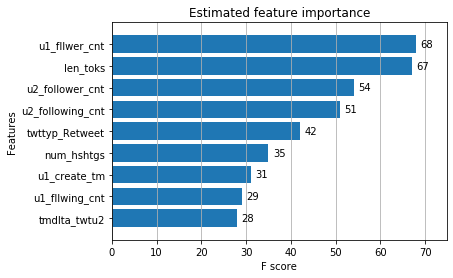

,0,1
2,u1_fllwer_cnt,68
3,len_toks,67
9,u2_follower_cnt,54
1,u2_following_cnt,51
6,twttyp_Retweet,42
18,num_hshtgs,35
15,u1_create_tm,31
13,u1_fllwing_cnt,29
17,tmdlta_twtu2,28
27,u2_create_tm,26


Reply


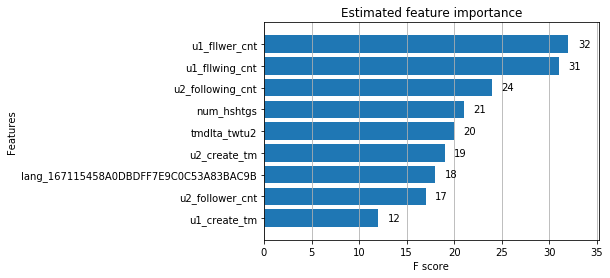

,0,1
9,u1_fllwer_cnt,32
12,u1_fllwing_cnt,31
4,u2_following_cnt,24
0,num_hshtgs,21
1,tmdlta_twtu2,20
20,u2_create_tm,19
8,lang_167115458A0DBDFF7E9C0C53A83BAC9B,18
6,u2_follower_cnt,17
18,u1_create_tm,12
7,lang_9BF3403E0EB7EA8A256DA9019C0B0716,12


Like


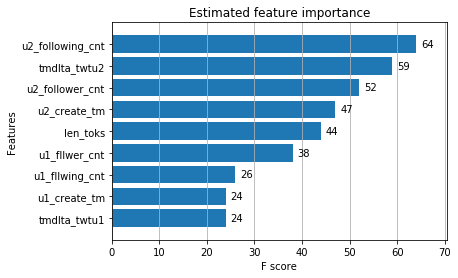

,0,1
5,u2_following_cnt,64
10,tmdlta_twtu2,59
6,u2_follower_cnt,52
3,u2_create_tm,47
2,len_toks,44
17,u1_fllwer_cnt,38
21,u1_fllwing_cnt,26
9,tmdlta_twtu1,24
11,u1_create_tm,24
15,tm,23


RTwCmnt


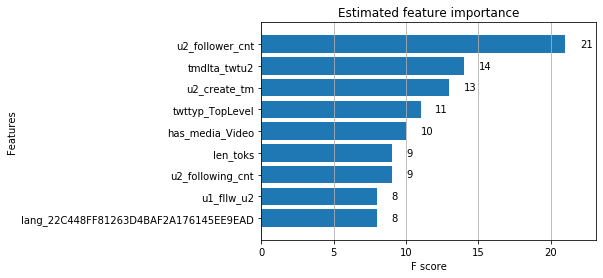

,0,1
0,u2_follower_cnt,21
18,tmdlta_twtu2,14
1,u2_create_tm,13
6,twttyp_TopLevel,11
10,has_media_Video,10
4,u2_following_cnt,9
8,len_toks,9
21,u1_fllw_u2,8
5,lang_22C448FF81263D4BAF2A176145EE9EAD,8
13,tmdlta_u2u1,6


In [18]:
for tgt,bst in tgt2bst.items():
    print(tgt)
    show_feat_importance(bst)

In [19]:
tgt2prdtr={}
tgt2prdvl={}
for tgt in tgts:
    print(dtnow(), tgt)
    bst = tgt2bst[tgt]
    tgt2prdtr[tgt] = bst.predict(dtr)
    tgt2prdvl[tgt] = bst.predict(dvl)
    

2020-03-20 03:24:23 Retweet
2020-03-20 03:24:24 Reply
2020-03-20 03:24:25 Like
2020-03-20 03:24:26 RTwCmnt


In [20]:
tgt2auc_trn={}
tgt2rce_trn={}
tgt2auc_val={}
tgt2rce_val={}
for itgt, tgt in enumerate(tgts):
    print(tgt)
    prdtr_i, prdvl_i = tgt2prdtr[tgt], tgt2prdvl[tgt]
    ytr_i, yvl_i = tgt2ytr[tgt], tgt2yvl[tgt]
    scr_rocauc_trn = roc_auc_score(ytr_i, prdtr_i)
    scr_rocauc_val = roc_auc_score(yvl_i, prdvl_i)
    scr_auc_trn=compute_prauc(prdtr_i, ytr_i)
    scr_rce_trn=compute_rce(prdtr_i, ytr_i)
    scr_auc_val=compute_prauc(prdvl_i, yvl_i)
    scr_rce_val=compute_rce(prdvl_i, yvl_i)

    tgt2auc_trn[tgt]=scr_auc_trn
    tgt2rce_trn[tgt]=scr_rce_trn
    tgt2auc_val[tgt]=scr_auc_val
    tgt2rce_val[tgt]=scr_rce_val
    
    print('train rocauc:', f'{scr_rocauc_trn:.4f}', 'valid auc:', f'{scr_rocauc_val:.4f}', )
    print('train prauc:', f'{scr_auc_trn:.4f}', 'valid auc:', f'{scr_auc_val:.4f}', )
    print('train rce:', f'{scr_rce_trn:.4f}', 'valid rce:', f'{scr_rce_val:.4f}', )

Retweet
train rocauc: 0.7173 valid auc: 0.7183
train prauc: 0.2915 valid auc: 0.2919
train rce: 8.3861 valid rce: 8.4161
Reply
train rocauc: 0.7552 valid auc: 0.7536
train prauc: 0.0907 valid auc: 0.0880
train rce: -4.4410 valid rce: -4.5395
Like
train rocauc: 0.7177 valid auc: 0.7171
train prauc: 0.6562 valid auc: 0.6557
train rce: 10.7123 valid rce: 10.6677
RTwCmnt
train rocauc: 0.6793 valid auc: 0.6791
train prauc: 0.0177 valid auc: 0.0168
train rce: -60.4923 valid rce: -60.2630


In [21]:
lsttrn=[]
lstval=[]
for tgt in ['Retweet','Reply','Like','RTwCmnt',]:
    lsttrn+=[(f'PRAUC {tgt}',tgt2auc_trn[tgt]),
          (f'RCE {tgt}',tgt2rce_trn[tgt])]
    lstval+=[(f'PRAUC {tgt}',tgt2auc_val[tgt]),
          (f'RCE {tgt}',tgt2rce_val[tgt])]

dfscrtrn=pd.DataFrame(lsttrn)
dfscrtrn.columns=['metric','scr']
dfscrval=pd.DataFrame(lstval)
dfscrval.columns=['metric','scr']
dfscr = pd.merge(dfscrtrn, dfscrval, on='metric', suffixes=('trn','val'))
dfscr.T

,0,1,2,3,4,5,6,7
metric,PRAUC Retweet,RCE Retweet,PRAUC Reply,RCE Reply,PRAUC Like,RCE Like,PRAUC RTwCmnt,RCE RTwCmnt
scrtrn,0.291465,8.38615,0.0906786,-4.44095,0.656217,10.7123,0.0177472,-60.4923
scrval,0.291944,8.41614,0.0879958,-4.53946,0.655673,10.6677,0.0168338,-60.263


# infer

In [22]:
%%time
dftst=pd.read_csv(
    f'{p_in}/val_{valtmstmp}.tsv',
#     f'{p_in}/val_259A6F6DFD672CB1F883CBEC01B99F2D_1584405047.tsv',
    sep='\x01', header=None, names=cols_val,)


The history saving thread hit an unexpected error (OperationalError('database is locked')).History will not be written to the database.
CPU times: user 1min 54s, sys: 10.2 s, total: 2min 4s
Wall time: 2min 10s


In [23]:
%%time
dftst = prp_df(dftst, istrn=False)

CPU times: user 1min 57s, sys: 13.3 s, total: 2min 11s
Wall time: 2min 19s


In [24]:
%%time
dtst = xgb.DMatrix(dftst[cols_feat], feature_names=cols_feat)
tgt2prdtst={}
for tgt in tgts:
    print(dtnow(), tgt)
    bst = tgt2bst[tgt]
    tgt2prdtst[tgt] = bst.predict(dtst)

2020-03-20 03:33:36 Retweet
2020-03-20 03:33:37 Reply
2020-03-20 03:33:38 Like
2020-03-20 03:33:39 RTwCmnt
CPU times: user 2min 48s, sys: 45.9 s, total: 3min 34s
Wall time: 3min 42s


In [25]:
dfsub_ids = dftst[['twtid','u2id',]]

tgt2dfsub = {}
for tgt,prdtst in tgt2prdtst.items():
    dfsub = dfsub_ids.copy()
    dfsub['scr'] = prdtst
    tgt2dfsub[tgt]=dfsub

In [26]:
%%time
for tgt, dfsub in tgt2dfsub.items():
    print(dtnow(), tgt)
    dfsub.to_csv(f'{p_out}/{tgt}__{valtmstmp}__{PRFX}.csv',index=False,header=False)

2020-03-20 03:33:42 Retweet
2020-03-20 03:34:41 Reply
2020-03-20 03:35:38 Like
2020-03-20 03:36:36 RTwCmnt
CPU times: user 3min 39s, sys: 6.94 s, total: 3min 46s
Wall time: 3min 52s
